# Keypoint Estimation Models Analysis

In [1]:
import os
import sys
import math
import git
import cv2
import numpy as np
import torch
import lightning as L
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(f"{git_root}/keypoint_estimation/")

## Loading data

In [54]:
from datamodule import KeypointEstDataModule

L.seed_everything(42, workers=True)

datamodule = KeypointEstDataModule(
    dataset_dir=os.path.join(
        os.path.expanduser("~"), "Documents/datasets"
    ),
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segsec",
    sample_num=16,
    seg_arg=8,
    neg_ratio=None,
    with_info=True,
    fast_load=True,
)
datamodule.setup()
train_dataset = datamodule.train_data
val_dataset = datamodule.val_data

datamodule.setup(stage="test")
test_dataset = datamodule.test_data

Global seed set to 42


Loading data from preprocessed annotation ...


## Model prediction

In [71]:
from system import KeypointEstModule

classifier = KeypointEstModule(
    model_name="hybrid",
    num_out_frames=1,
    mode="binary",
    # weight_path="/Users/shionyamadate/Documents/hands-and-objects/keypoint_estimation/logs/vivit_40epochs/vivit.pth",
    with_attention=True,
)
classifier.eval()

KeypointEstModule(
  (model): HybridViViT(
    (encoder_conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (encoder_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder_relu): ReLU(inplace=True)
    (encoder_maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2

### Visualize feature space

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


feature shape: (100, 1204992), label shape: (100,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.021s...
[t-SNE] Computed neighbors for 100 samples in 6.397s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 83.187125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.986389
[t-SNE] KL divergence after 1000 iterations: 0.423313


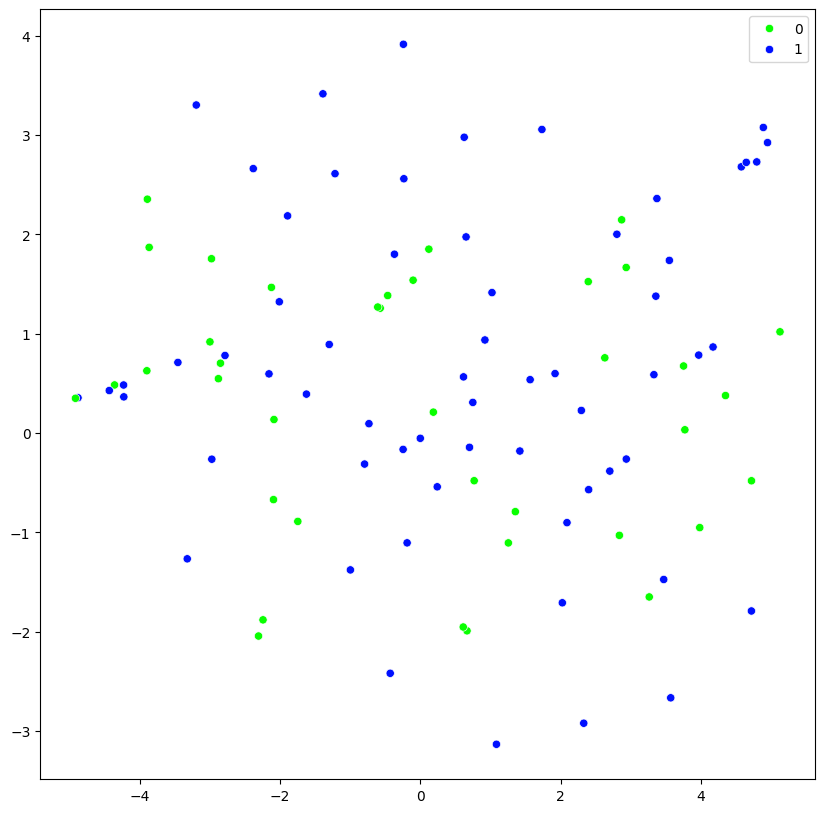

In [50]:
from sklearn.manifold import TSNE

# t-SNE for feature visualization
tsne = TSNE(n_components=2, random_state=42, verbose=1)

sampler = RandomSampler(train_dataset, num_samples=100)
dataloader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

feature_extractor = classifier.model.vivit
# i3d_resnet = torch.hub.load(
#     "facebookresearch/pytorchvideo", "i3d_r50", pretrained=True
# )
# i3d_resnet.blocks[6].proj = torch.nn.Identity()

features, bin_labels = [], []
for frames, labels, metalabels, info in tqdm(dataloader):
    with torch.no_grad():
        # get binary labels
        bin_labels.append(labels.max(dim=1, keepdim=True).values.int())

        # features to visualize
        feat, _ = feature_extractor(frames)
        # feat = i3d_resnet(frames.permute(0,2,1,3,4))
        features.append(feat)

bin_labels = np.vstack(bin_labels).flatten()
features = np.vstack(features).reshape(bin_labels.shape[0], -1)
print(f"feature shape: {features.shape}, label shape: {bin_labels.shape}")

reduced = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=reduced[:,0],
    y=reduced[:,1],
    hue=bin_labels,
    palette=sns.color_palette("hsv", 2),
)
plt.show()

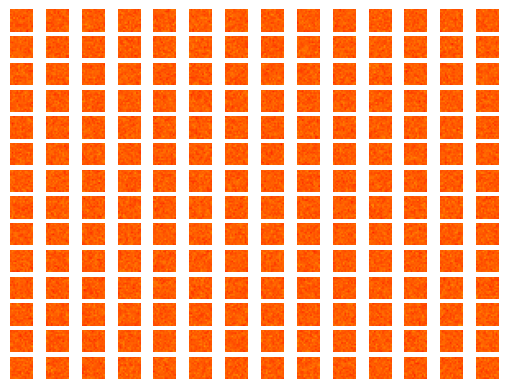

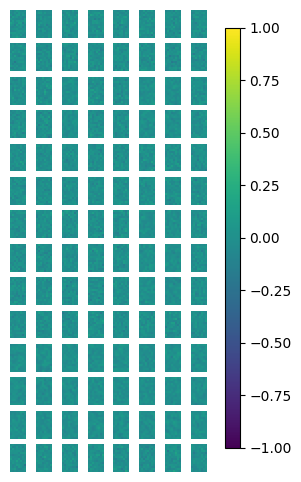

In [31]:
import torch.nn as nn
def checkpatch(model, model2):
    cos = nn.CosineSimilarity()

    num_patch_shape = (
        model.image_size // model.patch_size[2],
        model.image_size // model.patch_size[1],
        model.num_frames // model.patch_size[0],
    )

    pos_patch = model.embedding.pos_embed[:,model.num_cls_tokens:,:]
    pos_patch = pos_patch.view(-1, model.hidden_size, *num_patch_shape)

    pos_patch2 = model2.embedding.pos_embed[:,model.num_cls_tokens:,:]
    pos_patch2 = pos_patch2.view(-1, model.hidden_size, *num_patch_shape)

    def get_cos_similarity(pos_i, pos_j, pos_t):
        sims = np.empty(num_patch_shape)
        for i in range(num_patch_shape[0]):
            for j in range(num_patch_shape[1]):
                for t in range(num_patch_shape[2]):
                    sims[i,j,t] = cos(
                        pos_patch[:,:,pos_i,pos_j,pos_t],
                        pos_patch[:,:,i,j,t],
                    ) - cos(
                        pos_patch2[:,:,pos_i,pos_j,pos_t],
                        pos_patch2[:,:,i,j,t],
                    )
        return sims

    def create_2d_cos_similarity_xy_plot():
        fig = plt.figure()
        for pos_y in range(num_patch_shape[0]):
            for pos_x in range(num_patch_shape[1]):
                ax = fig.add_subplot(
                    *num_patch_shape[:-1],
                    1 + pos_x + pos_y * num_patch_shape[0],
                )
                ax.axis("off")
                plt.imshow(get_cos_similarity(pos_y, pos_x, 0)[:,:,0], vmin=-1, vmax=1)

        return fig
    
    import matplotlib.colors as clr
    import matplotlib.cm as cm
    def create_2d_cos_similarity_yt_plot():
        fig = plt.figure(figsize=(3, 6))
        for pos_t in range(num_patch_shape[2]):
            for pos_i in range(num_patch_shape[0]):
                ax = fig.add_subplot(
                    *num_patch_shape[1:],
                    1 + pos_t + pos_i * num_patch_shape[2],
                )
                ax.axis("off")
                plt.imshow(get_cos_similarity(pos_i, 0, pos_t)[:,0,:], vmin=-1, vmax=1)

        # create new axis for colorbar, and show
        plt.subplots_adjust(right=0.8)
        plt.colorbar(
            cm.ScalarMappable(norm=clr.Normalize(vmin=-1, vmax=1)),
            cax=fig.add_axes([0.85,0.15,0.05,0.7]),
        )

        return fig

    create_2d_cos_similarity_xy_plot()
    create_2d_cos_similarity_yt_plot()
    plt.show()

classifier = KeypointEstModule(
    model_name="vivit",
    num_out_frames=1,
    mode="binary",
    # weight_path="/Users/shionyamadate/Documents/hands-and-objects/keypoint_estimation/logs/vivit_40epochs/vivit.pth",
)
classifier.eval()

classifier2 = KeypointEstModule(
    model_name="vivit",
    num_out_frames=1,
    mode="binary",
    weight_path="/Users/shionyamadate/Documents/hands-and-objects/keypoint_estimation/logs/vivit_40epochs/vivit.pth",
)
classifier2.eval()
checkpatch(classifier.model.vivit, classifier2.model.vivit)

In [50]:
from IPython import display
import matplotlib.colors as clr
import matplotlib.cm as cm
import matplotlib.animation as animation
import torch.nn.functional as nnf

def visualize_patch_cos_similarity(model):
    num_patch_shape = (
        model.image_size // model.patch_size[2],
        model.image_size // model.patch_size[1],
        model.num_frames // model.patch_size[0],
    )

    pos_patch = model.embedding.pos_embed[:,model.num_cls_tokens:,:]
    pos_patch = pos_patch.view(-1, model.hidden_size, *num_patch_shape)

    def get_cos_similarity(pos_i, pos_j, pos_t):
        sims = np.empty(num_patch_shape)
        for i in range(num_patch_shape[0]):
            for j in range(num_patch_shape[1]):
                for t in range(num_patch_shape[2]):
                    sims[i,j,t] = nnf.cosine_similarity(
                        pos_patch[:,:,pos_i,pos_j,pos_t],
                        pos_patch[:,:,i,j,t],
                    )
        return sims

    def create_2d_cos_similarity_xy_plot():
        fig = plt.figure()

        def update(t):
            for pos_y in range(num_patch_shape[0]):
                for pos_x in range(num_patch_shape[1]):
                    ax = fig.add_subplot(
                        *num_patch_shape[:-1],
                        1 + pos_x + pos_y * num_patch_shape[0],
                    )
                    ax.axis("off")
                    plt.imshow(get_cos_similarity(
                        pos_y, pos_x, 4)[:,:,t], vmin=0, vmax=1
                    )

        ani = animation.FuncAnimation(
            fig, update, frames=range(8), interval=750
        )
        display.display(display.HTML(ani.to_jshtml()))
        plt.close()

    def create_2d_cos_similarity_yt_plot():
        fig = plt.figure(figsize=(3, 6))
        for pos_t in range(num_patch_shape[2]):
            for pos_i in range(num_patch_shape[0]):
                ax = fig.add_subplot(
                    *num_patch_shape[1:],
                    1 + pos_t + pos_i * num_patch_shape[2],
                )
                ax.axis("off")
                plt.imshow(get_cos_similarity(pos_i, 0, pos_t)[:,0,:])

        # create new axis for colorbar
        plt.subplots_adjust(right=0.8)
        plt.colorbar(
            cm.ScalarMappable(norm=clr.Normalize(vmin=0, vmax=1)),
            cax=fig.add_axes([0.85,0.15,0.05,0.7]),
        )

        plt.show()

    create_2d_cos_similarity_xy_plot()
    create_2d_cos_similarity_yt_plot()

visualize_patch_cos_similarity(classifier.model.vivit)

### Dataset prediction

In [69]:
sampler = RandomSampler(train_dataset, num_samples=200)
dataloader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

positive_preds = []
negative_preds = []
for frames, labels, metalabel, info in tqdm(dataloader):
    with torch.no_grad():
        logits = classifier(frames.float())
    preds = logits.sigmoid()

    if labels.max(dim=1, keepdims=True).values == 0:
        negative_preds.append(preds)
    else:
        positive_preds.append(preds)

100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


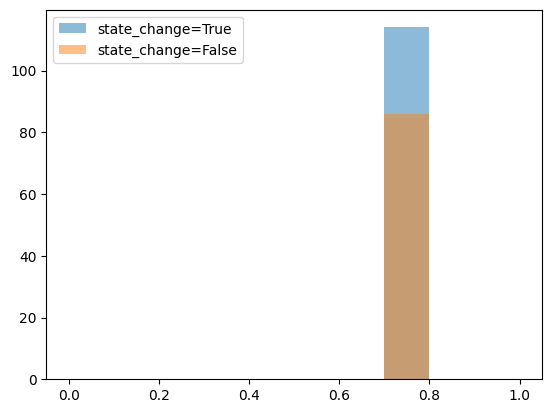

In [70]:
plt.hist(np.array(positive_preds).flatten(), range=(0,1), alpha=0.5, label="state_change=True")
plt.hist(np.array(negative_preds).flatten(), range=(0,1), alpha=0.5, label="state_change=False")

plt.legend()
plt.show()

### Single data prediction

In [79]:
import matplotlib.colors as clr
import matplotlib.cm as cm

def visualize_predictions(imgs, output):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(4, 4, 1+i)
        ax.axis("off")
        img = imgs[i]

        # add transparency
        w, h, _ = img.shape
        alpha = np.full((w,h,1), output[0][i] * 0.5 + 0.5)
        img = np.dstack([img, alpha])

        # add red surrounding box
        if labels[0][i] == 1:
            thickness = 5
            img[:thickness, :, :] = (1,0,0,1)
            img[-thickness:, :, :] = (1,0,0,1)
            img[:, :thickness, :] = (1,0,0,1)
            img[:, -thickness:, :] = (1,0,0,1)

        plt.imshow(img)

    plt.show()

def visualize_attention_maps(attention):
    fig = plt.figure()
    for layer in range(len(attention)):
        ax = fig.add_subplot(3, 4, 1+layer)
        ax.axis("off")

        att = attention[layer].mean(dim=1).squeeze(0).detach().numpy().copy()
        plt.imshow(att)
        plt.colorbar()

    plt.show()

def visualize_class_attention(
    imgs, attention, layer=-1, cls_token=0, cls_token_num=1, average_head=True,
    head=0, show_raw_map=False,
):
    # get class attention of layer (usually last layer)
    cls_att = attention[layer][:,:,cls_token,cls_token_num:]
    if average_head:
        cls_att = cls_att.mean(dim=1).squeeze(0)
    else:
        cls_att = cls_att.squeeze(0)[head]
    cls_att = cls_att.view(8,14,14).detach().numpy().copy()

    # visualize class attention maps
    if show_raw_map:
        fig = plt.figure()
        for d in range(int(len(imgs)/2)):
            ax = fig.add_subplot(2, 4, 1+d)
            ax.axis("off")
            plt.imshow(cls_att[d])
            plt.colorbar()

        plt.show()

    # visualize class attention maps with input frames
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(4, 4, 1+i)
        ax.axis("off")
        img = imgs[i]

        cls_att_map = cv2.resize(cls_att[math.floor(i/2)], (224,224))
        # normalize to range 0~1
        map_min, map_max = np.min(cls_att_map), np.max(cls_att_map)
        norm_map = (cls_att_map - map_min)/(map_max - map_min)

        plt.imshow(img)
        plt.imshow(norm_map, alpha=0.4, cmap="jet")

    # create new axis for colorbar, and show
    plt.subplots_adjust(right=0.8)
    plt.colorbar(
        cm.ScalarMappable(norm=clr.Normalize(vmin=0, vmax=1), cmap="jet"),
        cax=fig.add_axes([0.85,0.15,0.05,0.7]),
    )

    plt.show()

In [55]:
# prepare dataloader
sampler = SequentialSampler(test_dataset)
dataloader = DataLoader(test_dataset, batch_size=1, sampler=sampler)
iter_counter = 0

In [87]:
frames, labels, metalabel, info = next(iter(dataloader))
iter_counter += 1

imgs = frames.permute(0,1,3,4,2).detach().numpy().copy()[0]

with torch.no_grad():
    logits, attention = classifier(frames.float())
preds = logits.sigmoid()
output = (preds > (threshold:=0.5)).float()

print(
    f"iter counter: {iter_counter}",
    (
        f"vid: {info['video_uid'][0]} " + \
        f"from {int(info['segment_start_frame'])} " + \
        f"to {int(info['segment_end_frame'])} "
    ),
    f"frames shape: {frames.shape}",
    f"pnr frames: {info['parent_pnr_frame']}",
    f"converted frames shape: {imgs.shape}",
    f"labels: {labels}",
    f"binary label: {labels.max(dim=1, keepdims=True).values}",
    f"prediction: {preds}, output: {output}",
    sep="\n",
)

def add_pnr_annotation(frames, labels):
    ann_idx = np.where(labels == 1)[1]
    for i in ann_idx:
        w, h, _ = frames[i].shape
        frames[i] = cv2.rectangle(frames[i], (0,0), (w,h), (255,0,0), 5)
    return frames

# visualize images as gif
import matplotlib.animation as animation
from IPython import display
fig = plt.figure()
plots = [[plt.imshow(i)] for i in add_pnr_annotation(imgs, labels)]
ani = animation.ArtistAnimation(fig, plots, interval=500)
display.display(display.HTML(ani.to_jshtml()))

plt.clf()
plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter counter: 16
vid: 6834426d-9454-4fc9-a538-20d498d18e87 from 1 to 240 
frames shape: torch.Size([1, 16, 3, 224, 224])
pnr frames: [tensor([162])]
converted frames shape: (16, 224, 224, 3)
labels: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
binary label: tensor([[1]])
prediction: tensor([[0.6660]]), output: tensor([[1.]])


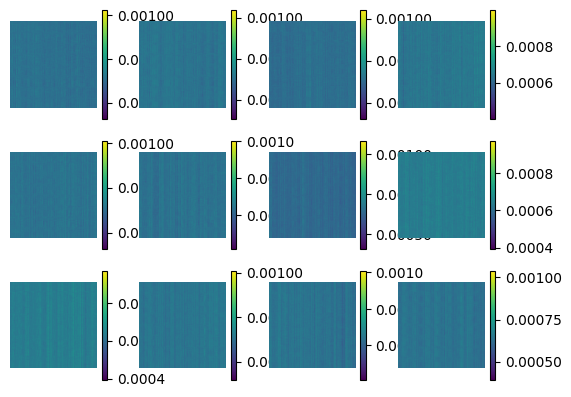

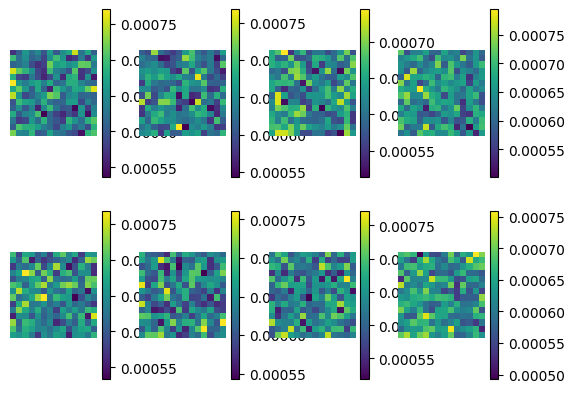

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


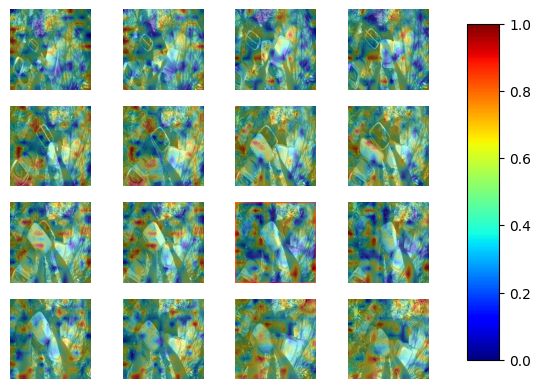

In [84]:
# visualize attention maps
visualize_attention_maps(attention)

# visualize class attention maps of last layer
visualize_class_attention(imgs, attention, show_raw_map=True, cls_token=0, cls_token_num=1)

### Comparison between pretrained data

In [ ]:
from system import KeypointEstModule

# prepare models (can be multiple)
classifier_list = [
    KeypointEstModule(
        model_name="vivit",
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="vivit",
        patch_size=[1, 224, 224],
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="vivit",
        patch_size=[1, 224, 224],
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="mctvivit",
        with_attention=True,
    )
]

weight_path_list = [
    f"{git_root}/keypoint_estimation/logs/vivit_cls/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/vivit_temp_phead/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/mctvivit/mctvivit.pth",
]

assert len(classifier_list) == len(weight_path_list)

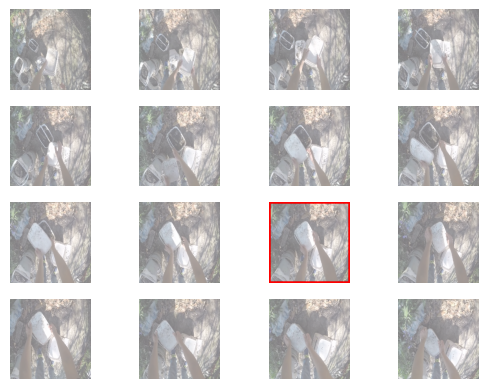

RuntimeError: shape '[8, 14, 14]' is invalid for input of size 1583

In [8]:
weight_paths = [
    f"{git_root}/keypoint_estimation/logs/asyml/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/asyml_mae/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/asyml_transunet/vivit.pth",
]

weight_dict = {
    "videomae_k400": f"{git_root}/keypoint_estimation/logs/checkpoint.pth",
    "transunet": f"{git_root}/keypoint_estimation/logs/transunet.pth",
}

from models import adjust_param
for k, v in weight_dict.items():
    param = torch.load(v, map_location=torch.device("cpu"))
    classifier.model.load_state_dict(
        adjust_param(param, k),
        strict=False,
    )
    classifier.eval()

    with torch.no_grad():
        logits, attention = classifier(frames.float())
    preds = logits.sigmoid()
    output = (preds > (threshold:=0.5)).float()

    visualize_predictions(imgs, output)
    visualize_class_attention(imgs, attention)

# for w in weight_paths:
#     classifier.model.load_state_dict(
#         torch.load(w, map_location=torch.device("cpu")),
#         strict=True,
#     )
#     classifier.eval()

#     with torch.no_grad():
#         logits, attention = classifier(frames.float())
#     preds = logits.sigmoid()
#     output = (preds > (threshold:=0.5)).float()

#     visualize_predictions(imgs, output)
#     visualize_attention_maps(attention)
#     visualize_class_attention(imgs, attention)

plt.clf()
plt.close()